# Лабораторная работа 2
### Выполнил: Шаров Савелий Михайлович

Добро пожаловать в лабораторную работу! 
Оформите ваше решение контеста Kaggle в соответствии с этим шаблоном. Ваша задача - показать проверяющим ход ваших рассуждений, поэтому советуем писать много комментариев к коду и приводить комментарии к логике на каждом этапе в текстовых ячейках. 
Где необходимо, используйте графики для большей наглядности.

При отправке поменяйте название файла на ваши ФИО!

### EDA (исследовательский анализ данных)

В этом разделе вам необходимо провести анализ вашего датасета, интерпретировать признаки, выяснить их значимость и исследовать зависимости между ними.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, make_scorer
from catboost import CatBoostClassifier, Pool

%matplotlib inline

In [2]:
features = pd.read_csv('DOTA2_TRAIN_features.csv', index_col='match_id')
target = pd.read_csv('DOTA2_TRAIN_targets.csv', index_col='match_id')
data = features.join(target, on='match_id')
data['radiant_win'] = data['radiant_win'].map({True: 1, False: 0})
data

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_win
match_id,,,,,,,,,,,,,,,,,,,,,
b29797296e310d2275f2cd67eeacf2eb,2117,22,7,15,1,5,4.0,9,15,0,...,3,1,7,0,0.405,0,0,0,0,0
49908f2a11d8bc01f6dad6fbf2e39326,3914,22,7,28,177,87,3.0,15,22,5,...,5,2,14,0,0.352,0,0,1,0,1
a68557919e4353f6067ddd3a04b980b0,100000000,22,0,6,1,42,0.0,0,1,1,...,0,0,10,0,0.625,0,0,0,0,1
f6273df443c5a8b192b633ef2ce34304,475,22,7,1,3,48,0.0,1,0,0,...,0,0,3,1,0.500,0,0,0,0,0
71b98e3c7cc8701ad425a69d3923ec8f,581,22,7,1,1,41,0.0,0,0,3,...,0,0,1,0,0.000,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
e72e4f287d02edbd8810c8fb3d3f08ee,1584,4,0,12,9,43,4.0,2,5,9,...,0,0,3,0,0.476,0,0,1,2,1
dc33aa0374dff2c15c4338e04d805c22,925,22,0,2,0,14,3.0,5,2,4,...,0,0,3,0,0.188,0,0,2,0,1
f3768ec35c1e9d1f7a778cd4423d7cb5,2522,22,7,16,12,34,16.0,6,10,6,...,0,0,0,0,0.077,0,0,0,0,1


Посчитаем корреляцию между каждым признаком и таргетом

In [3]:
corr_coefs = {}
coefs_data = pd.DataFrame(columns=['f_name', 'coef'])
for col in data.columns:
    if col == 'radiant_win':
        continue
    corr_coefs[col] = np.abs(np.corrcoef(data[col], data['radiant_win'])[0, 1])


coefs_data['f_name'] = corr_coefs.keys()
coefs_data['coef'] = corr_coefs.values()

coefs_data = coefs_data.sort_values(by='coef', ascending=False)

coefs_data.head(20)

,f_name,coef
66,r3_y,0.205868
186,d3_y,0.205151
42,r2_y,0.203232
138,d1_y,0.202011
18,r1_y,0.201326
90,r4_y,0.201125
162,d2_y,0.198739
234,d5_y,0.197784
114,r5_y,0.196422
210,d4_y,0.192250


### Данные явно имею нелинейную зависимость, думаю для модели хорошо подойдет градиентный бустинг

### Preprocessing (подготовка данных)

 В этом разделе вам необходимо реализовать подготовку ваших данных, в том числе заполнение пропусков, фильтрацию выбросов, кодирование категориальных признаков и т.д. В этот же раздел включите любые операции над данными, которые сочтете нужными.

Посмотрим пропуски

In [4]:
for col in data.columns:
    if data[col].isna().sum() != 0:
        print(f'{col}: {data[col].isna().sum()} missing values')

r1_kills: 2777 missing values
r2_kills: 2777 missing values
r3_kills: 2777 missing values
r4_kills: 2777 missing values
r5_kills: 2777 missing values


Ниже приведен код для выгрузки полезных данных из tome_of_knowledge

In [ ]:
json_data = pd.DataFrame(columns=['match_id', 'time', 'type', 'slot', 'key', 'player_slot'])
tok = pd.read_json('tome_of_knowledge.jsonl', lines=True, chunksize=1000)
for chunk in tok:
    for m_id, obj in chunk[['match_id', 'objectives']].values:
        for d in obj:
            if d['type'] == "CHAT_MESSAGE_FIRSTBLOOD":
                d['match_id'] = m_id
                json_data = json_data._append(d, ignore_index=True)
                break

json_data = json_data.set_index('match_id')
json_data.rename({'time' : 'fb_time'}, axis=1, inplace=True)
json_data.to_csv('fb.csv')

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001BA21A96230>>
Traceback (most recent call last):
  File "c:\Users\skygo\.conda\envs\ml-work\lib\site-packages\ipykernel\ipkernel.py", line 788, in _clean_thread_parent_frames
    if phase != "start":
KeyboardInterrupt: 
C:\Users\skygo\AppData\Local\Temp\ipykernel_17668\2441903239.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  json_data = json_data._append(d, ignore_index=True)


In [6]:
cols = ['r'+str(d)+'_gold' for d in range(1,6)] + ['r'+str(d)+'_lh' for d in range(1,6)] + ['r'+str(d)+'_kills' for d in range(1,6)] + ['r'+str(d)+'_xp' for d in range(1,6)]
cols += ['d'+str(d)+'_gold' for d in range(1,6)] + ['d'+str(d)+'_lh' for d in range(1,6)] + ['d'+str(d)+'_kills' for d in range(1,6)] + ['d'+str(d)+'_xp' for d in range(1,6)]

json_data = pd.DataFrame(columns=['match_id'] + cols)
json_data = json_data.set_index('match_id')

tok = pd.read_json('tome_of_knowledge.jsonl', lines=True, chunksize=100)
for chunk in tok:
    for m_id, r in chunk[['match_id', 'players']].values:
        stats_dict = {}
        for p in range(10):
            if p < 5:
                stats_dict[f"r{p+1}_gold"] = r[p]['gold']
                stats_dict[f"r{p+1}_lh"] = r[p]['lh']
                stats_dict[f"r{p+1}_kills"] = r[p]['kills']
                stats_dict[f"r{p+1}_xp"] = r[p]['xp']
            else:
                stats_dict[f"d{p-4}_gold"] = r[p]['gold']
                stats_dict[f"d{p-4}_lh"] = r[p]['lh']
                stats_dict[f"d{p-4}_kills"] = r[p]['kills']
                stats_dict[f"d{p-4}_xp"] = r[p]['xp']
        json_data.loc[m_id] = stats_dict

json_data.to_csv('player_stats.csv')

Загружаем данные

In [4]:
player_stats = pd.read_csv('player_stats.csv', index_col=0)
fb_data = pd.read_csv('fb.csv', index_col=0)
fb_data['r_fb'] = fb_data['slot'].map(lambda x: x < 5).map({True: 1, False: 0})

Добавляю информацию о firstblood в data, кроме того заполняю Nan'ы в киллах сил света данными из player_stats

In [5]:
data = data.join(fb_data[['fb_time', 'r_fb']])

data['r_fb'] = data['r_fb'].fillna(0)
data['fb_time'] = data['fb_time'].fillna(1000)
for d in range(1,6):
    data[f'r{d}_kills'] = player_stats.loc[data.index][f'r{d}_kills']

Поищем категориальные признаки

In [6]:
for x in data.columns:
    if len(data[x].unique()) < 10:
        print(x, len(data[x].unique()))

game_mode 8
lobby_type 2
r1_firstblood_claimed 2
r1_towers_killed 8
r1_roshans_killed 4
r2_firstblood_claimed 2
r2_towers_killed 9
r2_roshans_killed 5
r3_firstblood_claimed 2
r3_towers_killed 9
r3_roshans_killed 4
r4_firstblood_claimed 2
r4_towers_killed 9
r4_roshans_killed 4
r5_firstblood_claimed 2
r5_towers_killed 9
r5_roshans_killed 4
d1_firstblood_claimed 2
d1_towers_killed 8
d1_roshans_killed 5
d2_firstblood_claimed 2
d2_towers_killed 9
d2_roshans_killed 5
d3_firstblood_claimed 2
d3_roshans_killed 5
d4_firstblood_claimed 2
d4_roshans_killed 5
d5_firstblood_claimed 2
d5_towers_killed 9
d5_roshans_killed 5
radiant_win 2
r_fb 2


Из найденных признаков под категориальные подходят: game_mode, lobby_type, r_fb, firstblood_claimed. 
CatBoost и sklearn.HistGradientBoostingClassifier позваляют передать обработку категориальных признаков модели.

Уберем выбросы используя межквартальный размах

In [7]:
player_stats.columns

Index(['r1_gold', 'r2_gold', 'r3_gold', 'r4_gold', 'r5_gold', 'r1_lh', 'r2_lh',
       'r3_lh', 'r4_lh', 'r5_lh', 'r1_kills', 'r2_kills', 'r3_kills',
       'r4_kills', 'r5_kills', 'r1_xp', 'r2_xp', 'r3_xp', 'r4_xp', 'r5_xp',
       'd1_gold', 'd2_gold', 'd3_gold', 'd4_gold', 'd5_gold', 'd1_lh', 'd2_lh',
       'd3_lh', 'd4_lh', 'd5_lh', 'd1_kills', 'd2_kills', 'd3_kills',
       'd4_kills', 'd5_kills', 'd1_xp', 'd2_xp', 'd3_xp', 'd4_xp', 'd5_xp'],
      dtype='object')

In [8]:
def clear_data(df):
    # Заполним выбросы в некоторых фичах данными их player_stats
    for x in player_stats.columns:
        df[x] = player_stats.loc[df.index][x]

    for col in df.columns:
        if col in ['game_mode', 'lobby_type', 'objectives_len', 'chat_len', 'r_fb', 'radiant_win'] or col.count('hero_id') or col.count('kills') or col.count('deaths') or col.count('denies') or col.count('firstblood_claimed'):
            continue
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        if upper_bound > 0: # некоторые признаки имею много нулевых значения, из-за чего другие данные в них будут ложно классифироваться как выбросы.
            df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

Сгенерируем новые признаки, такие как винрейт героя, командные статистики и статистики для обеих команд

In [9]:
def calc_winrate(data):
    hero_cols = []

    for col in data.columns:
        if col.count('hero_id'):
            hero_cols.append(col)

    hero_winrate = dict()
    hero_matches = dict()
    for col in data[hero_cols + ['radiant_win']].values:
        for i in range(len(col) - 1):
            hero_winrate[col[i]] = hero_winrate.get(col[i], 0) + col[-1]
            hero_matches[col[i]] = hero_matches.get(col[i], 0) + 1
            
    for k, v in hero_matches.items():
        hero_winrate[k] /= v
    
    return hero_winrate


def add_winrate(data, hero_winrate):
    hero_cols = []

    for col in data.columns:
        if col.count('hero_id'):
            hero_cols.append(col)

    for col in hero_cols:
        player_hero_winrate = []
        for id in data[col].values:
            player_hero_winrate.append(hero_winrate.get(id, 0))

        data[col[:-2] + 'winrate'] = player_hero_winrate
    
    data['r_total_winrate'] = data[['r'+str(x)+'_hero_winrate' for x  in range(1, 6)]].sum(axis=1).div(5)
    data['d_total_winrate'] = data[['d'+str(x)+'_hero_winrate' for x  in range(1, 6)]].sum(axis=1).div(5)

def add_teams_stats(df):
    df['r_gold'] = df[["r"+str(n)+'_gold' for n in range(1, 6)]].sum(axis=1)
    df['r_xp'] = df[["r"+str(n)+'_xp' for n in range(1, 6)]].sum(axis=1)
    df['r_kills'] = df[["r"+str(n)+'_kills' for n in range(1, 6)]].sum(axis=1)
    df['r_obs'] = df[["r"+str(n)+'_obs_placed' for n in range(1, 6)]].sum(axis=1)
    df['r_sen'] = df[["r"+str(n)+'_sen_placed' for n in range(1, 6)]].sum(axis=1)
    df['r_rosh_killed'] = df[["r"+str(n)+'_roshans_killed' for n in range(1, 6)]].sum(axis=1)
    df['r_tower_killed'] = df[["r"+str(n)+'_towers_killed' for n in range(1, 6)]].sum(axis=1)
    df['r_creeps_stacked'] = df[["r"+str(n)+'_creeps_stacked' for n in range(1, 6)]].sum(axis=1)
    df['d_gold'] = df[["d"+str(n)+'_gold' for n in range(1, 6)]].sum(axis=1)
    df['d_xp'] = df[["d"+str(n)+'_xp' for n in range(1, 6)]].sum(axis=1)
    df['d_kills'] = df[["d"+str(n)+'_kills' for n in range(1, 6)]].sum(axis=1)
    df['d_obs'] = df[["d"+str(n)+'_obs_placed' for n in range(1, 6)]].sum(axis=1)
    df['d_sen'] = df[["d"+str(n)+'_sen_placed' for n in range(1, 6)]].sum(axis=1)
    df['d_rosh_killed'] = df[["d"+str(n)+'_roshans_killed' for n in range(1, 6)]].sum(axis=1)
    df['d_tower_killed'] = df[["d"+str(n)+'_towers_killed' for n in range(1, 6)]].sum(axis=1)
    df['d_creeps_stacked'] = df[["d"+str(n)+'_creeps_stacked' for n in range(1, 6)]].sum(axis=1)

def add_both_teams_stats(df):
    df['team_gold_diff'] = df['r_gold'] - df['d_gold']
    df['team_xp_diff'] = df['r_xp'] - df['d_xp']
    df['team_kills_diff'] = df['r_kills'] - df['d_kills']
    df['team_obs_diff'] = df['r_obs'] - df['d_obs']
    df['team_sen_diff'] = df['r_sen'] - df['d_sen']
    df['team_rosh_diff'] = df['r_rosh_killed'] - df['d_rosh_killed']
    df['team_towers_diff'] = df['r_tower_killed'] - df['d_tower_killed']
    df['team_creeps_diff'] = df['r_creeps_stacked'] - df['d_creeps_stacked']

In [ ]:
clear_data(data)
hero_winrate = calc_winrate(data)
add_winrate(data, hero_winrate)
add_teams_stats(data)
add_both_teams_stats(data)

Ещё раз посчитаем корреляцию и отбросим признаки, которые вообще не имеют связи с таргетом

In [11]:
corr_coefs = {}
coefs_data = pd.DataFrame(columns=['f_name', 'coef'])
for col in data.columns:
    if col == 'radiant_win':
        continue
    corr_coefs[col] = np.abs(np.corrcoef(data[col], data['radiant_win'])[0, 1])


coefs_data['f_name'] = corr_coefs.keys()
coefs_data['coef'] = corr_coefs.values()

coefs_data = coefs_data.sort_values(by='coef', ascending=False)

correlated_features = coefs_data[coefs_data['coef'] > 0.001]['f_name']
correlated_features

275       team_gold_diff
276         team_xp_diff
277      team_kills_diff
281     team_towers_diff
273       d_tower_killed
             ...        
2             lobby_type
245              fb_time
75         r3_obs_placed
77            r4_hero_id
68     r3_creeps_stacked
Name: f_name, Length: 278, dtype: object

In [ ]:
clear_data_df = data[correlated_features]

clear_data_df['game_mode'] = clear_data_df['game_mode'].astype(np.int64)
clear_data_df['r_fb'] = clear_data_df['r_fb'].astype(np.int64)

### Model & training (Выбор модели и её обучение)

В этом разделе описываете модель и ставите эксперименты по обучению.

Если вы ставили много экспериментов, приведите их в хронологическом порядке чтобы мы увидели эволюцию ваших рассуждений.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(clear_data_df, data['radiant_win'], test_size=0.33, random_state=1234)

#### Эксперимент 1
Попробуем разные реализации градиентного бустинга в sklearn

In [28]:
model1 = GradientBoostingClassifier(loss='exponential', random_state=1234)

model1.fit(X_train, y_train)

y_pred1 = model1.predict_proba(X_test)[:,1]

roc_auc_score(y_test, y_pred1)

0.8151579219009002

In [29]:
model2 = HistGradientBoostingClassifier(categorical_features=['game_mode', 'lobby_type', 'r_fb'] + [f'r{d}_firstblood_claimed' for d in range(1,6)] + [f'd{d}_firstblood_claimed' for d in range(1,6)], scoring=make_scorer(roc_auc_score), random_state=1234)

model2.fit(X_train, y_train)

y_pred2 = model2.predict_proba(X_test)[:,1]

roc_auc_score(y_test, y_pred2)

0.8128836734701674

#### Эксперимент 2
Попробуем выбросить некоторые сгенерированные фичи

In [30]:
clear_data_df = clear_data_df.drop(['r_gold', 'd_gold', 'r_kills', 'd_kills', 'r_obs', 'd_obs', 'r_sen', 'd_sen'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(clear_data_df, data['radiant_win'], test_size=0.33, random_state=1234)

In [31]:
model1 = GradientBoostingClassifier(loss='exponential', random_state=1234)

model1.fit(X_train, y_train)

y_pred1 = model1.predict_proba(X_test)[:,1]

roc_auc_score(y_test, y_pred1)

0.8161052985857781

In [25]:
model2 = HistGradientBoostingClassifier(categorical_features=['game_mode', 'lobby_type', 'r_fb'] + [f'r{d}_firstblood_claimed' for d in range(1,6)] + [f'd{d}_firstblood_claimed' for d in range(1,6)], scoring=make_scorer(roc_auc_score), random_state=1234)

model2.fit(X_train, y_train)

y_pred2 = model2.predict_proba(X_test)[:,1]

roc_auc_score(y_test, y_pred2)

0.8117062932668304

Вывод: Без выброшенных фичей оценка модели стала лучше

#### Эксперимент 3
Попробуем библиотеку CatBoost

In [153]:
cat_f = ['game_mode', 'lobby_type', 'r_fb'] + [f'r{d}_firstblood_claimed' for d in range(1,6)] + [f'd{d}_firstblood_claimed' for d in range(1,6)]

In [64]:
model3 = CatBoostClassifier(cat_features=cat_f, random_seed=1234, verbose=False)

model3.fit(X=X_train, y=y_train)

y_pred3 = model3.predict_proba(X_test)[:,1]

roc_auc_score(y_test, y_pred3)

0.8179138573430933

In [97]:
model3.get_params()

{'random_seed': 1234,
 'verbose': False,
 'cat_features': ['game_mode',
  'lobby_type',
  'r_fb',
  'r1_firstblood_claimed',
  'r2_firstblood_claimed',
  'r3_firstblood_claimed',
  'r4_firstblood_claimed',
  'r5_firstblood_claimed',
  'd1_firstblood_claimed',
  'd2_firstblood_claimed',
  'd3_firstblood_claimed',
  'd4_firstblood_claimed',
  'd5_firstblood_claimed']}

Посмотрим важность фичей

In [117]:
f_imp_df = model3.get_feature_importance(prettified=True)

In [137]:
f_imp_df[f_imp_df['Importances'] > 0.1]

,Feature Id,Importances
0,team_gold_diff,14.158659
1,team_xp_diff,4.727172
2,team_towers_diff,1.443352
3,team_kills_diff,1.374432
4,r4_hero_winrate,1.250897
...,...,...
181,r1_level,0.112700
182,d5_towers_killed,0.108565
183,r5_creeps_stacked,0.108007
184,r1_rune_pickups,0.104950


Попробуем взять более менее важные фичи

In [143]:
f_imp = f_imp_df[f_imp_df['Importances'] > 0.1]['Feature Id']

In [144]:
X_train, X_test, y_train, y_test = train_test_split(clear_data_df[f_imp], data['radiant_win'], test_size=0.33, random_state=1234)

In [146]:
model3 = CatBoostClassifier(random_seed=1234, verbose=False)

model3.fit(X=X_train, y=y_train)

y_pred3 = model3.predict_proba(X_test)[:,1]

roc_auc_score(y_test, y_pred3)

0.8188082756760618

Вывод: Отобранные CatBoost фичи дают улучшение оценки 

#### Эксперимент 4

##### Попробуем подобрать параметры для улучшения оценки

Поиск оптимального значения iterations

In [150]:
X_train, X_test, y_train, y_test = train_test_split(clear_data_df, data['radiant_win'], test_size=0.33, random_state=1234)

In [151]:
train_data = Pool(data=X_train, label=y_train)
eval_data = Pool(data=X_test, label=y_test)

model = CatBoostClassifier(random_seed=1234, iterations=100000, use_best_model=True, eval_metric="AUC", od_type='Iter')

model.fit(X=X_train, y=y_train, eval_set=eval_data)

Learning rate set to 0.008801
0:	test: 0.7868147	best: 0.7868147 (0)	total: 41.1ms	remaining: 1h 8m 27s
1:	test: 0.7930972	best: 0.7930972 (1)	total: 77.6ms	remaining: 1h 4m 37s
2:	test: 0.8000390	best: 0.8000390 (2)	total: 136ms	remaining: 1h 15m 19s
3:	test: 0.8037085	best: 0.8037085 (3)	total: 179ms	remaining: 1h 14m 35s
4:	test: 0.8045108	best: 0.8045108 (4)	total: 213ms	remaining: 1h 10m 56s
5:	test: 0.8059668	best: 0.8059668 (5)	total: 252ms	remaining: 1h 9m 52s
6:	test: 0.8061362	best: 0.8061362 (6)	total: 287ms	remaining: 1h 8m 13s
7:	test: 0.8061699	best: 0.8061699 (7)	total: 322ms	remaining: 1h 7m 9s
8:	test: 0.8062829	best: 0.8062829 (8)	total: 357ms	remaining: 1h 6m 10s
9:	test: 0.8067580	best: 0.8067580 (9)	total: 398ms	remaining: 1h 6m 17s
10:	test: 0.8076606	best: 0.8076606 (10)	total: 433ms	remaining: 1h 5m 35s
11:	test: 0.8072258	best: 0.8076606 (10)	total: 467ms	remaining: 1h 4m 54s
12:	test: 0.8072083	best: 0.8076606 (10)	total: 500ms	remaining: 1h 4m 2s
13:	test: 0.

In [152]:
model.get_best_iteration()

789

In [ ]:
model3 = CatBoostClassifier(cat_features=cat_f, random_seed=1234, verbose=False, iterations=789)

model3.fit(X=X_train, y=y_train)

y_pred3 = model3.predict_proba(X_test)[:,1]

roc_auc_score(y_test, y_pred3)

0.8190168141095949

Используя GridSearch найдем другие параметры

In [157]:
grid_model = CatBoostClassifier(cat_features=cat_f, random_seed=1234, iterations=789, eval_metric="AUC")
grid = {
    'depth': [4, 6],
    'leaf_estimation_iterations': [10, 20],
    'bagging_temperature': [0, 1, 5, 10]
}
grid_res = grid_model.grid_search(grid, X=clear_data_df, y=data['radiant_win'], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7692928	best: 0.7692928 (0)	total: 46.1ms	remaining: 36.4s
1:	test: 0.7824559	best: 0.7824559 (1)	total: 97.6ms	remaining: 38.4s
2:	test: 0.7852243	best: 0.7852243 (2)	total: 145ms	remaining: 38s
3:	test: 0.7906889	best: 0.7906889 (3)	total: 195ms	remaining: 38.2s
4:	test: 0.7983562	best: 0.7983562 (4)	total: 239ms	remaining: 37.4s
5:	test: 0.8020163	best: 0.8020163 (5)	total: 292ms	remaining: 38.1s
6:	test: 0.8041843	best: 0.8041843 (6)	total: 333ms	remaining: 37.2s
7:	test: 0.8044879	best: 0.8044879 (7)	total: 375ms	remaining: 36.6s
8:	test: 0.8045797	best: 0.8045797 (8)	total: 417ms	remaining: 36.1s
9:	test: 0.8058791	best: 0.8058791 (9)	total: 464ms	remaining: 36.1s
10:	test: 0.8065508	best: 0.8065508 (10)	total: 520ms	remaining: 36.8s
11:	test: 0.8065532	best: 0.8065532 (11)	total: 562ms	remaining: 36.4s
12:	test: 0.8068397	best: 0.8068397 (12)	total: 608ms	remaining: 36.3s
13:	test: 0.8069099	best: 0.8069099 (13)	total: 648ms	remaining: 35.9s
14:	test: 0.8069808	best: 

По результатам поиска лучшими параметрами оказались depth 4, leaf_estimation_iterations=20, bagging_temperature=0

### Evaluation (оценка качества модели)

В этом разделе проводите оценку качества вашей итоговой модели. 

In [170]:
X_train, X_test, y_train, y_test = train_test_split(clear_data_df[f_imp], data['radiant_win'], test_size=0.33, random_state=1234)

In [ ]:
model = CatBoostClassifier(iterations=780, depth=4, bagging_temperature=0, leaf_estimation_iterations=20, random_seed=1234, verbose=False)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)[:,1]

In [172]:
from sklearn.metrics import log_loss, brier_score_loss, precision_recall_curve, auc

In [173]:
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC-AUC: {roc_auc}')

# Log Loss
logloss = log_loss(y_test, y_pred)
print(f'Log Loss: {logloss}')

# Brier Score Loss
brier = brier_score_loss(y_test, y_pred)
print(f'Brier Score Loss: {brier}')

# Precision-Recall Curve и PR-AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
print(f'Precision-Recall AUC: {pr_auc}')

ROC-AUC: 0.8191896808669544
Log Loss: 0.5115202356997431
Brier Score Loss: 0.17258576208553272
Precision-Recall AUC: 0.8334425612554865


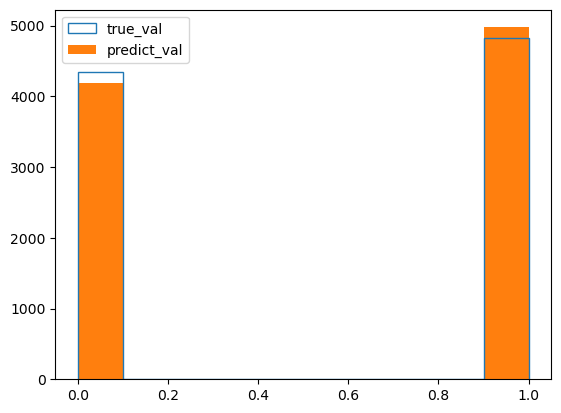

In [200]:
plt.hist(y_test.values, histtype='step', label='true_val')
plt.hist(model.predict(X_test), label='predict_val')
plt.legend()
plt.show()

### Conclusion (Выводы)

В этом разделе описываете полученные результаты и проводите анализ выполненной работы. 
Что получилось / не получилось и почему?

Получилось загрузить данные из большого json, найти подходящую модель, сгенерировать новые фичи.
Не получилось проанализировать взаимосвязь между признаками, провести хорошее удаление выбросов.

### То что я отправил в Kaggle:

In [ ]:
test_data = pd.read_csv('DOTA2_TEST_features.csv', index_col='match_id')
test_data = test_data.join(fb_data[['fb_time', 'r_fb']])
for d in range(1,6):
    test_data[f'r{d}_kills'] = player_stats.loc[test_data.index][f'r{d}_kills']
test_data['r_fb'] = test_data['r_fb'].fillna(0)
test_data['fb_time'] = test_data['fb_time'].fillna(1000)

clear_data(test_data)
add_winrate(test_data, hero_winrate)
add_teams_stats(test_data)
add_both_teams_stats(test_data)

test_data['game_mode'] = test_data['game_mode'].astype(np.int64)
test_data['r_fb'] = test_data['r_fb'].astype(np.int64)

model_k = CatBoostClassifier(cat_features=cat_f, random_seed=1234, iterations=1302, verbose=False)

model_k.fit(clear_data_df, data['radiant_win'])

y_pred = model_k.predict_proba(test_data[correlated_features].drop(['r_gold', 'd_gold', 'r_kills', 'd_kills', 'r_obs', 'd_obs', 'r_sen', 'd_sen'], axis=1))

submission = pd.DataFrame(y_pred[:, 1], index=test_data.index, columns=['radiant_win'])
submission.to_csv('my_solve.csv')